In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import classification_report, RocCurveDisplay

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [2]:
os.chdir("/Users/shenchingfeng/GitHub/ML-Forest-Fire-Prediction-with-Regression-and-Classification")

In [9]:
f = 'data/transformed_df.csv'
df = pd.read_csv(f)

In [10]:
df[df['area'] != 0]['area'].describe()

count     270.000000
mean       24.600185
std        86.501635
min         0.090000
25%         2.140000
50%         6.370000
75%        15.422500
max      1090.840000
Name: area, dtype: float64

In [11]:
target = ["no fire", "small fire", "large fire"]

for i in range(len(df)):
    
    if df['area'][i] == 0:
        df['area'][i] = "no fire"
    
    elif df['area'][i] < 6.37 and df['area'][i] > 0:
        df['area'][i] = "small fire"

    elif df['area'][i] >= 6.37:
        df['area'][i] = "large fire"

print(df['area'].value_counts())

no fire       247
small fire    135
large fire    135
Name: area, dtype: int64


# Three Categories

## Original Data

Workflow:

1. `pd.get_dummies` for Categorical data (X, Y, month, day)

2. `StandardScaler` for Continuous data

3. `np.hstack` the Categorical data (in dummy variables form) and Standardized Continuous data

4. `train_test_split` with train / test ratio = 0.8 / 0.2

5. `model.fit()`

6. `model.predict()`

In [12]:
cat_col = ['X', 'Y', 'month', 'day']
con_col = ['rain_YJ', 'FFMC_YJ', 'DMC_YJ', 'DC_YJ', 'ISI_YJ', 'temp_YJ', 'RH_YJ', 'wind_YJ']

In [13]:
x = df.drop(columns = ['area'])
y = df['area']

cat_dummy = pd.get_dummies(x, columns = cat_col, dtype = float)
d = pd.DataFrame(cat_dummy)
con = d[con_col]
cat = d.drop(columns = con_col)

In [118]:
## Standardize Continuous data
scl = StandardScaler()
con_scl = scl.fit_transform(con)

## Data with Standardized continuous data + Dummy categorical data
d_scl = np.hstack((con_scl, cat))

In [119]:
x_train, x_test, y_train, y_test = train_test_split(d_scl, y, train_size = 0.8)

### Logistic Regression

In [120]:
model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_score = model.predict_proba(x_test)

In [121]:
print(classification_report(y_test, y_pred, target_names = target))

              precision    recall  f1-score   support

     no fire       0.18      0.09      0.12        33
  small fire       0.49      0.73      0.59        49
  large fire       0.43      0.27      0.33        22

    accuracy                           0.43       104
   macro avg       0.37      0.37      0.35       104
weighted avg       0.38      0.43      0.39       104



Text(0.5, 1.0, 'Logistic Regression\nOne vs Rest ROC curve')

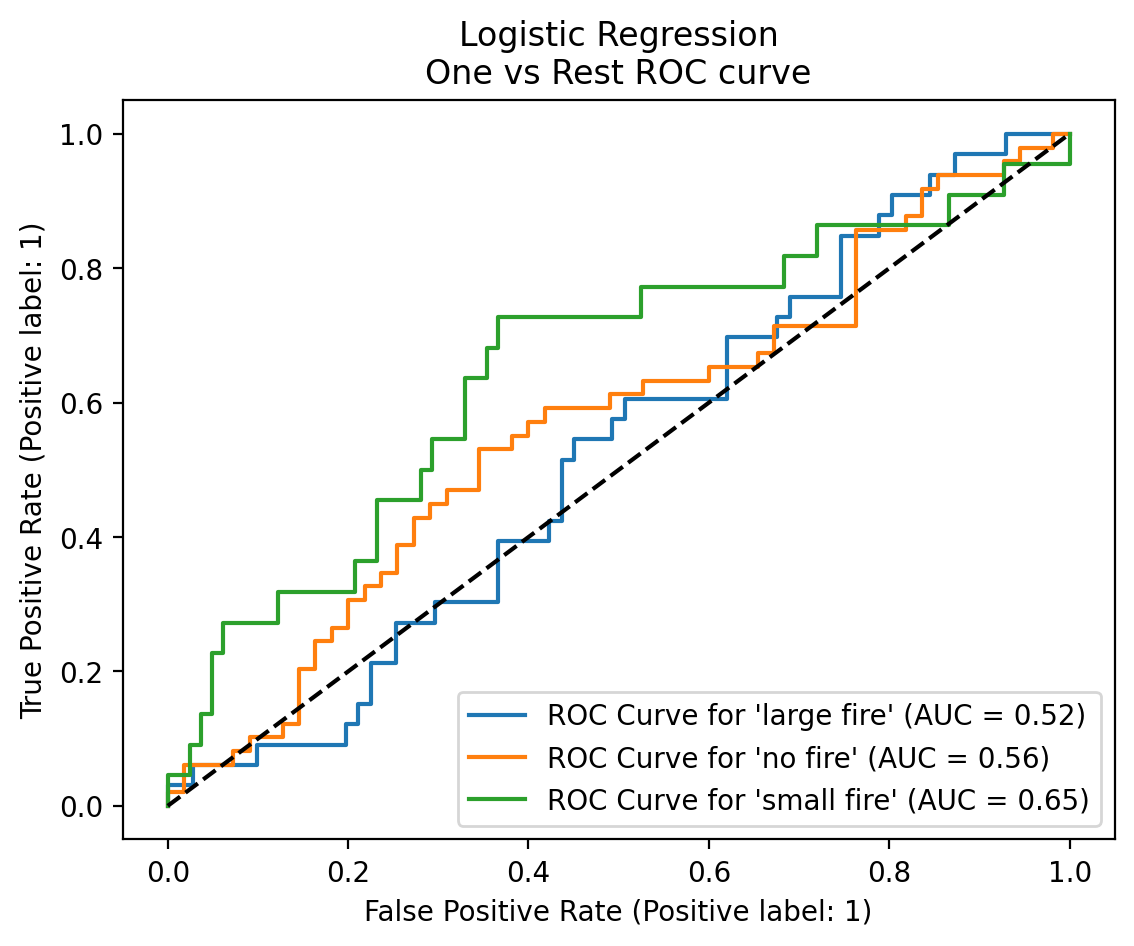

In [122]:
label_binarizer = LabelBinarizer().fit(y_train)
y_test_bin = label_binarizer.transform(y_test)

fig, ax = plt.subplots()

for id in range(3):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, id],
        y_pred_score[:, id],
        name = f"ROC Curve for '{model.classes_[id]}'",
        ax = ax
    )

plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.title("Logistic Regression\nOne vs Rest ROC curve")

### SVC

In [123]:
model = svm.SVC(probability = True)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_score = model.predict_proba(x_test)

In [124]:
print(classification_report(y_test, y_pred, target_names = target))

              precision    recall  f1-score   support

     no fire       0.33      0.03      0.06        33
  small fire       0.47      0.94      0.63        49
  large fire       0.25      0.05      0.08        22

    accuracy                           0.46       104
   macro avg       0.35      0.34      0.25       104
weighted avg       0.38      0.46      0.33       104



Text(0.5, 1.0, 'SVC\nOne vs Rest ROC curve')

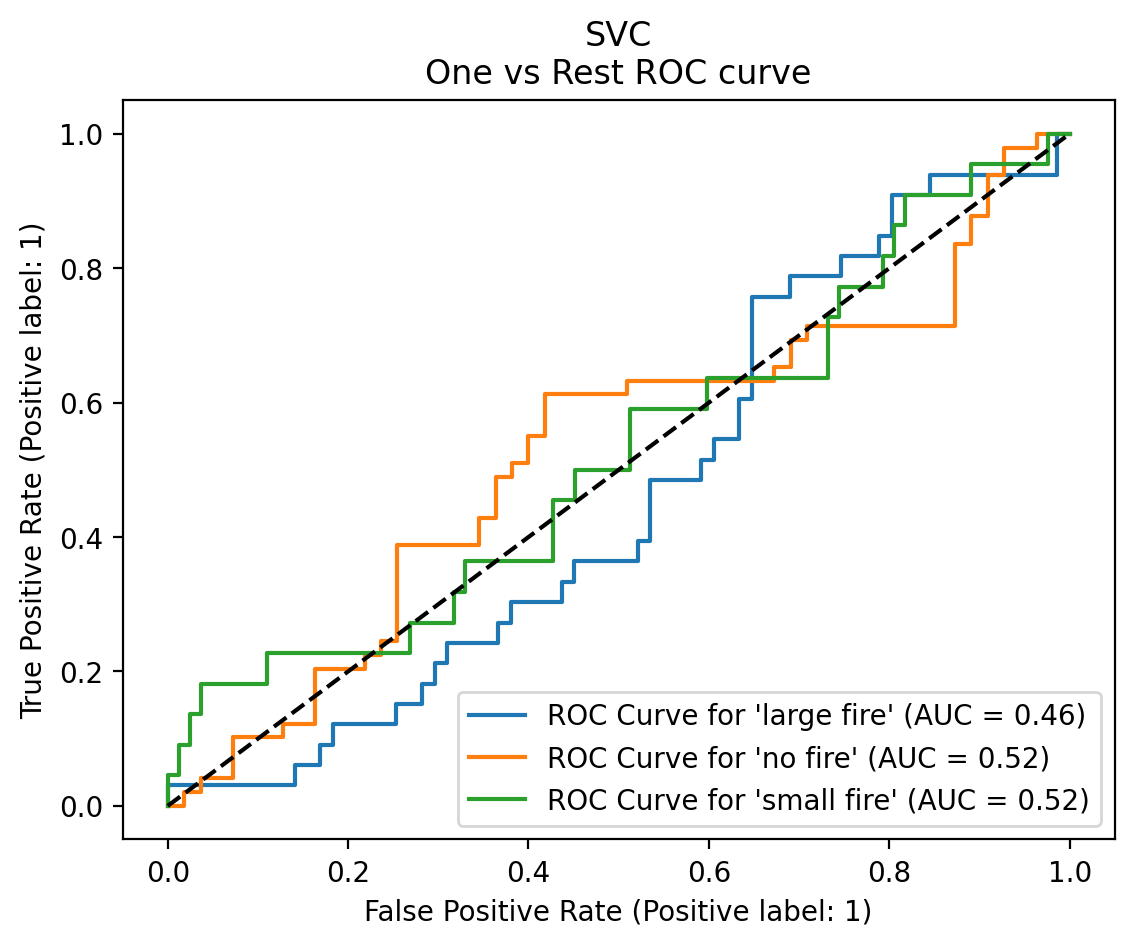

In [125]:
label_binarizer = LabelBinarizer().fit(y_train)
y_test_bin = label_binarizer.transform(y_test)

fig, ax = plt.subplots()

for id in range(3):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, id],
        y_pred_score[:, id],
        name = f"ROC Curve for '{model.classes_[id]}'",
        ax = ax
    )

plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.title("SVC\nOne vs Rest ROC curve")

## Upsample Data

Workflow:

0. `SMOTENC` Upsample data by [SMOTENC](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html)

1. `pd.get_dummies` for Categorical data (X, Y, month, day)

2. `StandardScaler` for Continuous data

3. `np.hstack` the Categorical data (in dummy variables form) and Standardized Continuous data

4. `train_test_split` with train / test ratio = 0.8 / 0.2

5. `model.fit()`

6. `model.predict()`

In [15]:
x

,X,Y,month,day,FFMC_YJ,DMC_YJ,DC_YJ,ISI_YJ,temp_YJ,RH_YJ,wind_YJ,rain_YJ
0,7,5,mar,fri,6.915111e+23,11.210981,510.798250,2.651479,12.896172,3.546171,2.919204,-0.000000
1,7,4,oct,tue,1.302164e+24,13.802504,8655.255527,3.154089,34.185421,3.201249,0.715340,-0.000000
2,7,4,oct,sat,1.302164e+24,15.939223,8990.709234,3.154089,26.308982,3.201249,0.959408,-0.000000
3,8,6,mar,fri,1.518165e+24,13.234439,385.397812,3.776617,13.088851,4.045679,2.127207,0.010535
4,8,6,mar,sun,1.083562e+24,17.770738,573.422693,3.924487,19.345114,4.061314,1.227405,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,3.445043e+23,19.013029,8589.762984,1.326891,59.129161,3.176706,1.638364,-0.000000
513,2,4,aug,sun,3.445043e+23,19.013029,8589.762984,1.326891,43.745051,3.804877,2.679465,-0.000000
514,7,4,aug,sun,3.445043e+23,19.013029,8589.762984,1.326891,41.991071,3.793855,2.919204,-0.000000
515,1,4,aug,sat,2.195970e+24,35.651094,7655.029144,4.317942,53.272284,3.392903,2.127207,-0.000000


In [16]:
smote = SMOTENC(categorical_features = [0, 1, 2, 3], sampling_strategy = "auto")
x_smote, y_smote = smote.fit_resample(x, y)

print(x.shape, y.shape)
print(x_smote.shape, y_smote.shape)

(517, 12) (517,)
(741, 12) (741,)


In [127]:
cat_dummy = pd.get_dummies(x_smote, columns = cat_col, dtype = float)
d = pd.DataFrame(cat_dummy)
con = d[con_col]
cat = d.drop(columns = con_col)

In [128]:
## Standardize Continuous data
scl = StandardScaler()
con_scl = scl.fit_transform(con)

## Data with Standardized continuous data + Dummy categorical data
d_scl = np.hstack((con_scl, cat))

In [129]:
x_train, x_test, y_train, y_test = train_test_split(d_scl, y_smote, train_size = 0.8)

In [130]:
model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_score = model.predict_proba(x_test)

In [131]:
print(classification_report(y_test, y_pred, target_names = target))

              precision    recall  f1-score   support

     no fire       0.49      0.32      0.39        59
  small fire       0.38      0.38      0.38        48
  large fire       0.38      0.57      0.46        42

    accuracy                           0.41       149
   macro avg       0.42      0.42      0.41       149
weighted avg       0.42      0.41      0.40       149



Text(0.5, 1.0, 'Logistic Regression\nOne vs Rest ROC curve')

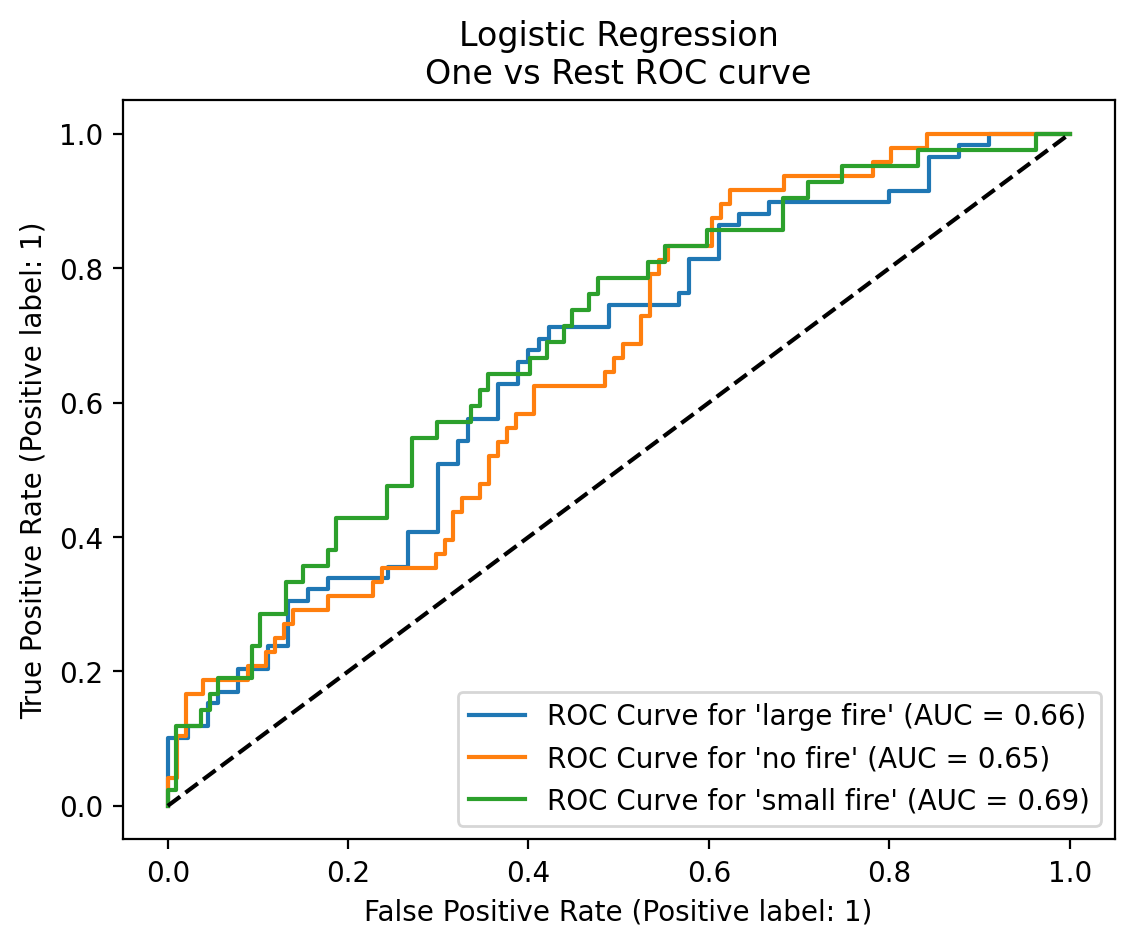

In [132]:
label_binarizer = LabelBinarizer().fit(y_train)
y_test_bin = label_binarizer.transform(y_test)

fig, ax = plt.subplots()

for id in range(3):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, id],
        y_pred_score[:, id],
        name = f"ROC Curve for '{model.classes_[id]}'",
        ax = ax
    )

plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.title("Logistic Regression\nOne vs Rest ROC curve")

### SVC

In [133]:
model = svm.SVC(probability = True)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_score = model.predict_proba(x_test)

In [134]:
print(classification_report(y_test, y_pred, target_names = target))

              precision    recall  f1-score   support

     no fire       0.53      0.44      0.48        59
  small fire       0.53      0.48      0.51        48
  large fire       0.49      0.67      0.57        42

    accuracy                           0.52       149
   macro avg       0.52      0.53      0.52       149
weighted avg       0.52      0.52      0.51       149



Text(0.5, 1.0, 'SVC\nOne vs Rest ROC curve')

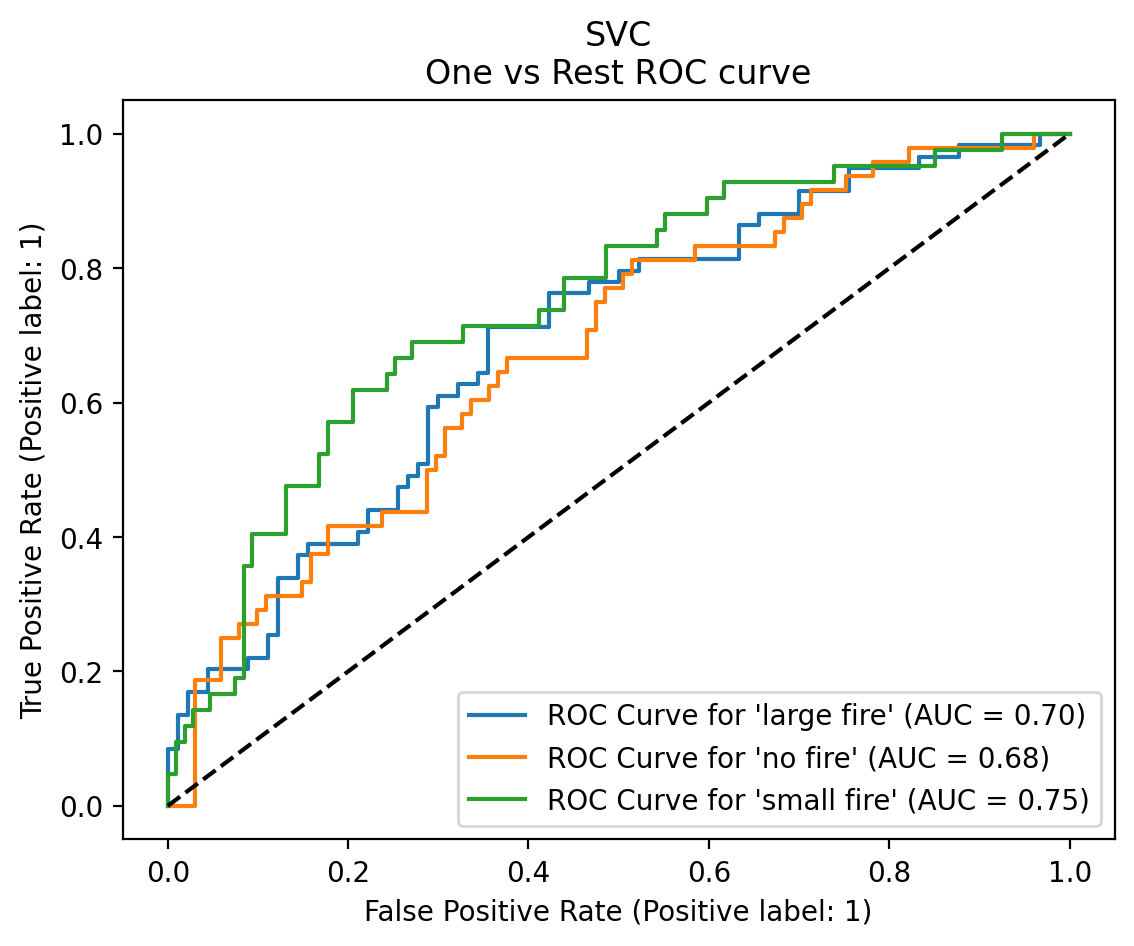

In [135]:
label_binarizer = LabelBinarizer().fit(y_train)
y_test_bin = label_binarizer.transform(y_test)

fig, ax = plt.subplots()

for id in range(3):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, id],
        y_pred_score[:, id],
        name = f"ROC Curve for '{model.classes_[id]}'",
        ax = ax
    )

plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.title("SVC\nOne vs Rest ROC curve")